In [3]:
%matplotlib widget

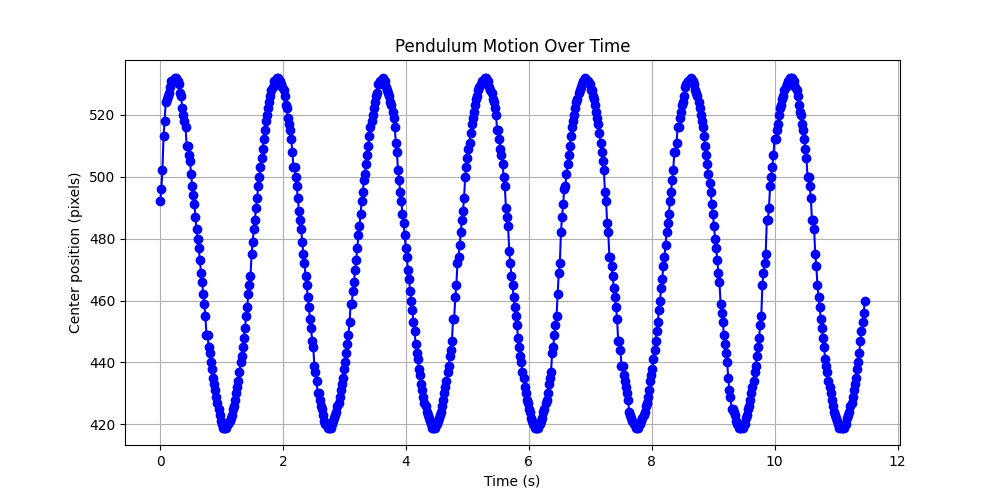

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time  

# Dummy function for the trackbar
def nothing(i):     
    pass  

# Create a window and a trackbar to adjust the lower blue threshold
cv2.namedWindow("concat")
cv2.createTrackbar("low_blue", "concat", 170, 255, nothing)  

# Read video from file
video_path = "video.mp4"   
cam = cv2.VideoCapture(video_path) 
# cam = cv2.VideoCapture(0)  

# Physical parameters
L = 0.7  # Length of the pendulum (m)
T = 30   # maximum recording duration (s) 
fps = cam.get(cv2.CAP_PROP_FPS)  # Get FPS of the video
start_time = time.time()  # Start time measurement  

# Data for analysis
positions = []  # List to store x center positions over time
times = []  # List to store timestamps  

while True:
    success, frame = cam.read()  
    frame = cv2.resize(frame, (960, 540))  # Resize frame  

    if not success:
        break  

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time  
    if elapsed_time > T:
        break  # Stop after t = 30 seconds  

    # Get the trackbar position for low blue threshold
    low_blue = cv2.getTrackbarPos("low_blue", "concat")  

    # Create a mask to detect blue objects in the frame
    mask1 = cv2.inRange(frame, (low_blue, 0, 0), (255, 155, 155))  

    # Apply erosion to remove noise
    ksz = 7  
    kernel = np.ones((ksz, ksz))  
    eroded = cv2.erode(mask1, kernel)  

    # Concatenate original mask and eroded mask for visualization
    concat = np.concatenate((mask1, eroded), axis=1)  

    # Detect connected components in the eroded mask
    output = cv2.connectedComponentsWithStats(eroded)  
    num_components = output[0]  
    stats = output[2]  

    center_x = None  

    for i in range(num_components):
        top    = stats[i, cv2.CC_STAT_TOP]  
        left   = stats[i, cv2.CC_STAT_LEFT]  
        width  = stats[i, cv2.CC_STAT_WIDTH]  
        height = stats[i, cv2.CC_STAT_HEIGHT]  
        area = stats[i, cv2.CC_STAT_AREA]  

        # Filter objects based on area size to exclude noise
        if 100 < area < 400:  
            center_x = left + width // 2  # Get the center of the detected object
            cv2.rectangle(frame, (left, top), (left + width, top + height), (123, 234, 234), 5)  

    if center_x is not None:
        # Record the object's x center position and the corresponding time
        frame_time = len(times) / fps  
        positions.append(center_x)  
        times.append(frame_time)  

    # Display the processed images
    cv2.imshow("concat", concat)  
    cv2.imshow("window", frame)  

    # Press 'q' to exit  
    key = cv2.waitKey(30)  
    if key == ord('q'):
        break  

# Release resources
cam.release()  
cv2.destroyAllWindows()  
cv2.waitKey(30)  

# Plot x center position over time
plt.figure(figsize=(10, 5))  
plt.plot(times, positions, marker='o', linestyle='-', color='b')  
plt.xlabel("Time (s)")  
plt.ylabel("Center position (pixels)")  
plt.title("Pendulum Motion Over Time")  
plt.grid(True)  
plt.show()


$ t_1 = 0.242 c;  t_2 = 10.270 c;  l = 0.7 м$

Из графика видно, что за время $\Delta t = t_2 - t_1 = 10.270 - 0.242 = 10.028 с$ математический маятник совершает $6$ колебаний, следовательно, период колебаний маятника равен $T = \frac{\Delta t}{6} = 1.671 с$.

Ускорение свободного падения вычисляется по формуле:
$$g = \frac{4\pi^2 l}{T^2} = 9.897 м/c^2$$.